## Refine Myeloid cell annotations for large intestine - relabelling uncertain cells based on majority voting

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import ast

In [2]:
sc.logging.print_header()

scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.3.5 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.2


In [3]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
sc.set_figure_params(
    dpi=200,dpi_save=300,
    fontsize=12,
    frameon=False,
    transparent=True,
)

In [5]:
sns.set_style(style="white")
sns.set_context(context="paper")

In [6]:
adata = sc.read_h5ad('/nfs/team205/ao15/Megagut/Annotations_v3/h5ad/disease/compartments/Myeloid_pooled_disease.gene_cellbender.good_qc_cluster_mito80.stringent_doublet_removed.hvg7500_noCC.scvi_output.lv20_batch256.with_raw_counts.scArches_broad_pred.20230124.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 18221 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

In [8]:
adata_scanvi = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/X_scANVI/disease/disease_fine_annot_predict_Myeloid_20230226.csv.gz',compression='gzip',index_col=0)

In [9]:
adata_scanvi

LV1       LV2       LV3       LV4  \
index                                                                      
AACGTTGCACATCCGG-4918STDY7273964 -0.112569 -0.100826  0.074933 -0.161024   
AACGTTGGTCTGGTCG-4918STDY7273964 -0.006792  0.456930  0.054259 -0.010730   
ACACCCTTCCACTGGG-4918STDY7273964 -0.062644 -0.210652  0.067213 -0.137204   
ACCGTAATCCAGTAGT-4918STDY7273964 -0.059507  0.473951  0.084855 -0.131927   
ACGGAGAAGGCCATAG-4918STDY7273964 -0.051205 -0.136943  0.037529 -0.120102   
...                                    ...       ...       ...       ...   
TTCTACACAAAGGTGC-GSM4546346      -0.067644 -0.302776 -0.038199 -0.058417   
TTGCCGTCACCTCGGA-GSM4546346      -0.094833 -0.565015  0.006136 -0.071545   
TTGCCGTCATCCTTGC-GSM4546346      -0.107833  1.255753  0.126814 -0.154888   
TTGGCAACACAGATTC-GSM4546346      -0.017317 -0.296456  0.086503 -0.121298   
TTTGTCAGTCGCCATG-GSM4546346      -0.026199 -0.818710  0.000276 -0.100576   

                                       LV5       LV6       LV7       LV8  \
index                                                                      
AACGTTGCACATCCGG-4918STDY7273964 -0.951867 -2.406589 -0.072623 -0.974680   
AACGTTGGTCTGGTCG-4918STDY7273964  1.459248 -0.117249 -0.029403 -0.102549   
ACACCCTTCCACTGGG-4918STDY7273964 -0.374680 -1.132450 -0.049296 -0.512336   
ACCGTAATCCAGTAGT-4918STDY7273964  0.783788 -0.119713 -0.050485 -0.665735   
ACGGAGAAGGCCATAG-4918STDY7273964 -0.849402 -0.513476 -0.021127  0.538718   
...                                    ...       ...       ...       ...   
TTCTACACAAAGGTGC-GSM4546346      -1.211132  0.080967  0.011157 -1.700076   
TTGCCGTCACCTCGGA-GSM4546346      -0.156330 -0.980786 -0.017541 -2.259642   
TTGCCGTCATCCTTGC-GSM4546346       0.868575 -1.704775 -0.033831  0.015951   
TTGGCAACACAGATTC-GSM4546346      -0.017555 -1.309027 -0.049632 -0.223150   
TTTGTCAGTCGCCATG-GSM4546346      -1.784420 -0.857111 -0.032927 -0.917515   

                                       LV9      LV10      LV11      LV12  \
index                                                                      
AACGTTGCACATCCGG-4918STDY7273964  0.349273  0.124162  0.110668  0.127304   
AACGTTGGTCTGGTCG-4918STDY7273964 -0.676454 -0.063304  0.013695  0.584019   
ACACCCTTCCACTGGG-4918STDY7273964  0.842808 -0.028618  0.036911  0.980405   
ACCGTAATCCAGTAGT-4918STDY7273964  0.736144 -0.038481 -0.019527 -2.572984   
ACGGAGAAGGCCATAG-4918STDY7273964  1.106296 -0.077136 -0.008611  1.503432   
...                                    ...       ...       ...       ...   
TTCTACACAAAGGTGC-GSM4546346       0.040767 -0.023786 -0.005778  0.772300   
TTGCCGTCACCTCGGA-GSM4546346      -2.244462 -0.125547 -0.000721 -0.866460   
TTGCCGTCATCCTTGC-GSM4546346       0.513549 -0.049415  0.022006  1.968374   
TTGGCAACACAGATTC-GSM4546346       0.331237  0.179460  0.082904  0.428884   
TTTGTCAGTCGCCATG-GSM4546346       0.214467  0.163217  0.106472 -0.196371   

                                      LV13      LV14      LV15      LV16  \
index                                                                      
AACGTTGCACATCCGG-4918STDY7273964  0.044043  0.000055  0.102898 -0.094656   
AACGTTGGTCTGGTCG-4918STDY7273964  0.058644  0.116801  0.074464 -0.292093   
ACACCCTTCCACTGGG-4918STDY7273964  0.026192 -0.076069  0.112568 -0.005082   
ACCGTAATCCAGTAGT-4918STDY7273964  0.010009 -0.083272  0.004927  1.237161   
ACGGAGAAGGCCATAG-4918STDY7273964  0.018933 -0.119689  0.118129  0.591252   
...                                    ...       ...       ...       ...   
TTCTACACAAAGGTGC-GSM4546346       0.010234  0.004012  0.062601  1.545818   
TTGCCGTCACCTCGGA-GSM4546346       0.095269 -0.032431 -0.079334  0.979460   
TTGCCGTCATCCTTGC-GSM4546346      -0.024999 -0.029609  0.185919 -1.069336   
TTGGCAACACAGATTC-GSM4546346       0.028254  0.145816  0.056296 -1.164149   
TTTGTCAGTCGCCATG-GSM4546346       0.038028  0.001019  0.025331  0.667854   

                                      LV17      LV18      LV19      LV20  
index   

In [10]:
adata.obsm['X_scANVI'] = adata_scanvi

In [11]:
adata_meta = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_Myeloid_20230226.csv',index_col=0)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (84,100) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
adata_meta

latent_cell_probability  \
index                                                       
AACGTTGCACATCCGG-4918STDY7273964                 0.999860   
AACGTTGGTCTGGTCG-4918STDY7273964                 0.999263   
ACACCCTTCCACTGGG-4918STDY7273964                 0.999898   
ACCGTAATCCAGTAGT-4918STDY7273964                 0.999764   
ACGGAGAAGGCCATAG-4918STDY7273964                 0.999833   
...                                                   ...   
TTCTACACAAAGGTGC-GSM4546346                      0.999416   
TTGCCGTCACCTCGGA-GSM4546346                      0.999773   
TTGCCGTCATCCTTGC-GSM4546346                      0.999798   
TTGGCAACACAGATTC-GSM4546346                      0.999931   
TTTGTCAGTCGCCATG-GSM4546346                      0.999626   

                                  latent_RT_efficiency cecilia22_predH  \
index                                                                    
AACGTTGCACATCCGG-4918STDY7273964              1.762105     Macrophages   
AACGTTGGTCTGGTCG-4918STDY7273964              0.813128     Macrophages   
ACACCCTTCCACTGGG-4918STDY7273964              2.394783     Macrophages   
ACCGTAATCCAGTAGT-4918STDY7273964              1.324064      Mast cells   
ACGGAGAAGGCCATAG-4918STDY7273964              2.045614     Macrophages   
...                                                ...             ...   
TTCTACACAAAGGTGC-GSM4546346                   0.956914     Macrophages   
TTGCCGTCACCTCGGA-GSM4546346                   1.198864             pDC   
TTGCCGTCATCCTTGC-GSM4546346                   1.324768              DC   
TTGGCAACACAGATTC-GSM4546346                   2.633427     Macrophages   
TTTGTCAGTCGCCATG-GSM4546346                   1.551974     Macrophages   

                                  cecilia22_predH_prob  \
index                                                    
AACGTTGCACATCCGG-4918STDY7273964              0.786272   
AACGTTGGTCTGGTCG-4918STDY7273964              0.169987   
ACACCCTTCCACTGGG-4918STDY7273964              0.996379   
ACCGTAATCCAGTAGT-4918STDY7273964              0.998680   
ACGGAGAAGGCCATAG-4918STDY7273964              0.529783   
...                                                ...   
TTCTACACAAAGGTGC-GSM4546346                   0.901446   
TTGCCGTCACCTCGGA-GSM4546346                   0.977038   
TTGCCGTCATCCTTGC-GSM4546346                   0.261010   
TTGGCAACACAGATTC-GSM4546346                   0.999890   
TTTGTCAGTCGCCATG-GSM4546346                   0.362724   

                                 cecilia22_predH_uncertain  \
index                                                        
AACGTTGCACATCCGG-4918STDY7273964               Macrophages   
AACGTTGGTCTGGTCG-4918STDY7273964                 Uncertain   
ACACCCTTCCACTGGG-4918STDY7273964               Macrophages   
ACCGTAATCCAGTAGT-4918STDY7273964                Mast cells   
ACGGAGAAGGCCATAG-4918STDY7273964               Macrophages   
...                                                    ...   
TTCTACACAAAGGTGC-GSM4546346                    Macrophages   
TTGCCGTCACCTCGGA-GSM4546346                            pDC   
TTGCCGTCATCCTTGC-GSM4546346                      Uncertain   
TTGGCAACACAGATTC-GSM4546346                    Macrophages   
TTTGTCAGTCGCCATG-GSM4546346                    Macrophages   

                                                cecilia22_predL  \
index                                                             
AACGTTGCACATCCGG-4918STDY7273964                            DC2   
AACGTTGGTCTGGTCG-4918STDY7273964  Erythrophagocytic macrophages   
ACACCCTTCCACTGGG-4918STDY7273964                            DC2   
ACCGTAATCCAGTAGT-4918STDY7273964                     Mast cells   
ACGGAGAAGGCCATAG-4918STDY7273964                            DC2   
...                                                         ...   
TTCTACACAAAGGTGC-GSM4546346            Intermediate macrophages   
TTGCCGTCACCTCGGA-GSM4546346                                 pDC   
TTGCCGTCATCCTTGC-GSM4546346                  

In [13]:
adata.obs = adata_meta

In [14]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


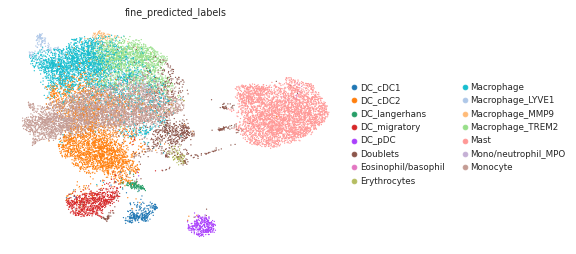

In [15]:
sc.pl.umap(adata, color=['fine_predicted_labels'])

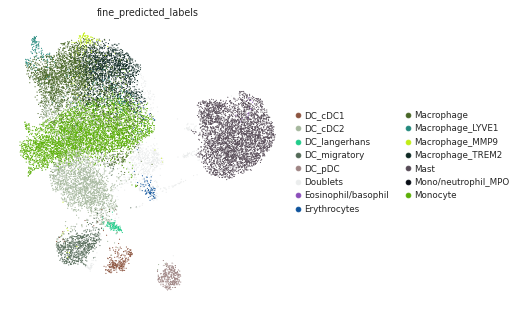

In [16]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels',palette = ['#8c543f',#DC_cDC1
'#a5b79d',#DC_cDC2
'#20cc8a',#DC_langerhans
'#536957',#DC_migratory
'#9e8483',#DC_pDC
 '#ebeded',#doublets
'#8b4eba',#Eosinophil/basophil
'#0e539c',#Erythrocytes
'#486626',#Macrophage
#'#caf9cf',#Macrophage_CD5L
'#23897d',#Macrophage_LYVE1
'#c1ed15',#Macrophage_MMP9
'#0d2823',#Macrophage_TREM2
'#564a56',#Mast
#'#c730aa',#Megakaryocyte/platelet
'#070c14',#Mono/neutrophil_MPO
'#5baf07']#Monocyte                                
           ,size=5,save='Mye_scanviannot_predicted_labels.pdf')

In [17]:
adata.X.max()

11278.0

In [18]:
adata.layers['counts'] = adata.X

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [20]:
marker_genes_dict = {'cDC1':['CLEC9A','IDO1','XCR1'],
                    'cDC2':['FCER1A','CD1C','CLEC10A'],
                    'Langerhans cells':['ITGAX','IL22RA2','RUNX3'],
                    'Migratory DCs':['CCR7','LAMP3','CD83'],
                    'Plasmacytoid DCs':['IRF7','GZMB','JCHAIN','LILRA4'],
                    'Eosinophils/basophils':['CNRIP1','PRG2','GIHCG'],
                    'Erythrocytes':['HBZ','HBE1','HBG1'],
                    'Macrophage general markers':['C1QA','CD68','APOE','CD209'],
                    'Macrophage_CD5L':['CD5L','VCAM1','CXCL12','PDK4','RBP7'],
                    'Macrophage_LYVE1':['LYVE1','RNASE1','FOLR2'],
                    'Macrophage_MMP9':['MMP9','PLA2G2D','ADAMDEC1'],
                    'Macrophage_TREM2':['TREM2','ACP5','CTSD','CSTB'],
                    'Mast':['TPSB2','TPSAB1','CD69'],
                    'Megakaryocyte/platelet':['MMRN1','CMTM5','MPIG6B','ITGA2B','PF4'],
                    'Mono/neutrophil_MPO':['MPO','RETN','RNASE2','PCLAF'],
                    'Monocyte':['CD14','EREG','NAMPT','PLAUR','VCAN','FPR1']}

In [21]:
adata

AnnData object with n_obs × n_vars = 18221 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


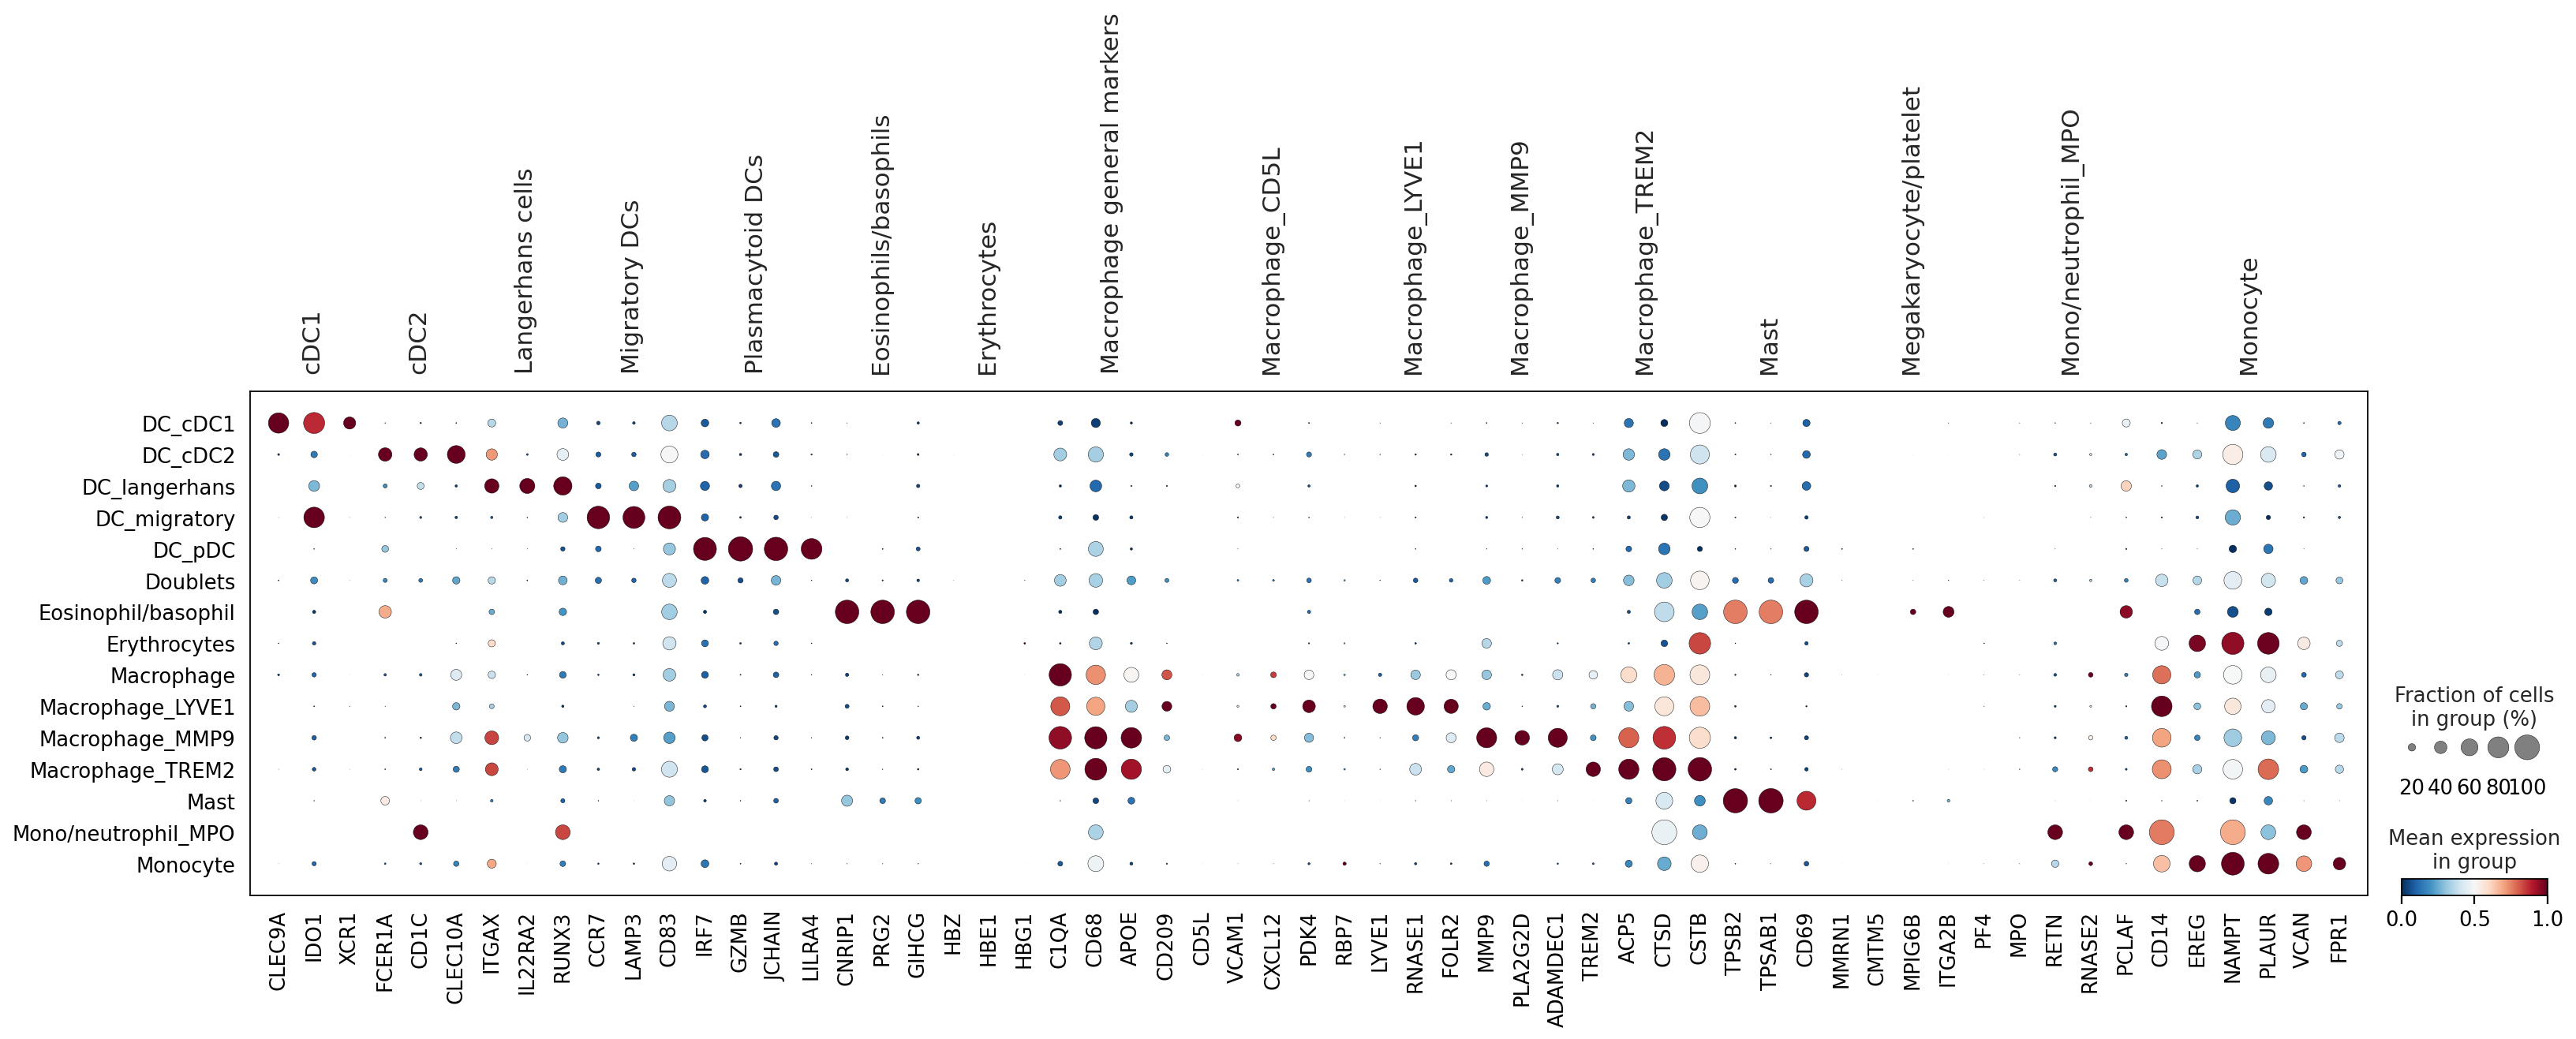

In [22]:
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels',color_map='RdBu_r', standard_scale='var',save='Mye_scanviannot_markers.pdf')

In [23]:
uncert = adata.obs[['fine_predicted_labels','fine_predicted_labels_uncertainty']] 

In [24]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(adata.obs['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.5199918448925018


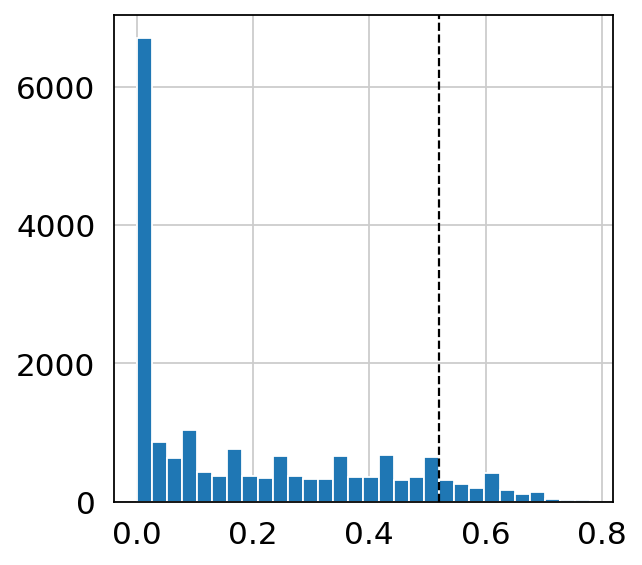

In [25]:
#plot uncertainty distribution
plt.hist(adata.obs['fine_predicted_labels_uncertainty'], bins=30)
plt.axvline(x=p, color='black', linestyle='dashed', linewidth=1)
plt.savefig('Mye_scanviannot_uncertdist.pdf', format='pdf')
plt.show()

In [26]:
uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')

<ipython-input-26-905f2ed234d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')


In [27]:
adata.obs['fine_predicted_labels'].unique()

['DC_cDC2', 'Doublets', 'Mast', 'Monocyte', 'Macrophage_MMP9', ..., 'Erythrocytes', 'Mono/neutrophil_MPO', 'DC_langerhans', 'Macrophage_LYVE1', 'Eosinophil/basophil']
Length: 15
Categories (15, object): ['DC_cDC1', 'DC_cDC2', 'DC_langerhans', 'DC_migratory', ..., 'Macrophage_TREM2', 'Mast', 'Mono/neutrophil_MPO', 'Monocyte']

In [28]:
#mark cells are unknown based on cut off of 90th percentile rounded to the nearest second decimal
uncert.loc[uncert["fine_predicted_labels_uncertainty"] > 0.52, "fine_predicted_labels"] = "Unknown"

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [29]:
adata.obs['fine_predicted_labels_uncertflagged'] = adata.obs['fine_predicted_labels']

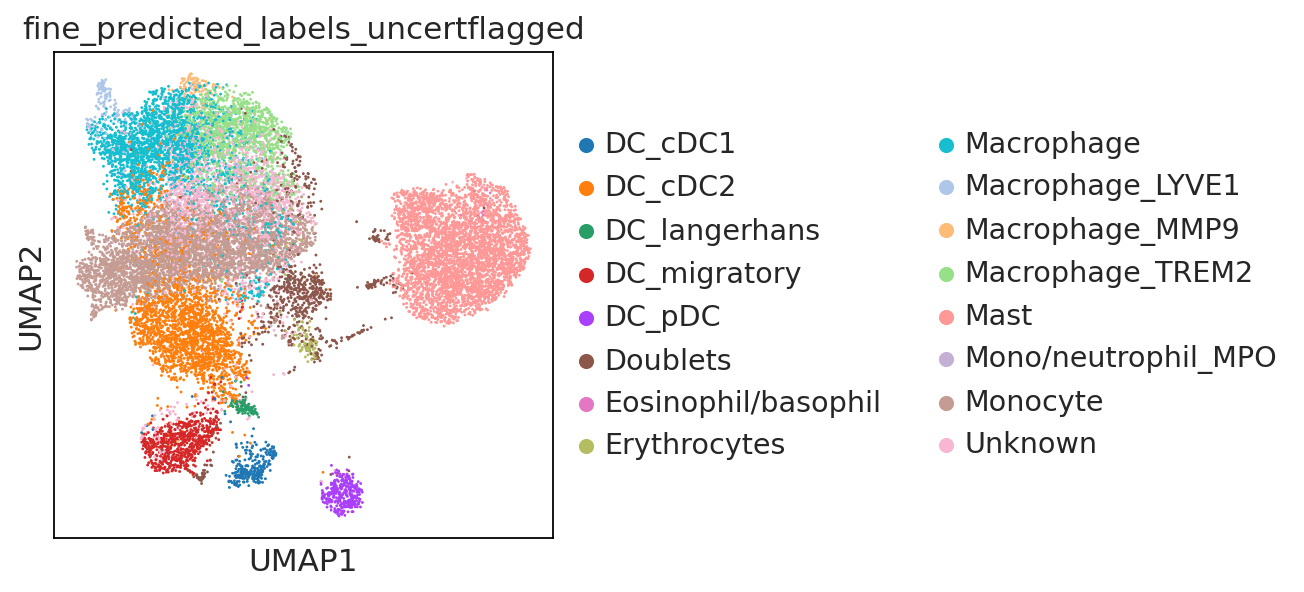

In [30]:
ON = {O:N for O,N in zip(uncert.index,uncert["fine_predicted_labels"])}
adata.obs["fine_predicted_labels_uncertflagged"] = [ON[O] if O in ON else N for O,N in zip(adata.obs_names, adata.obs["fine_predicted_labels_uncertflagged"])]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged')

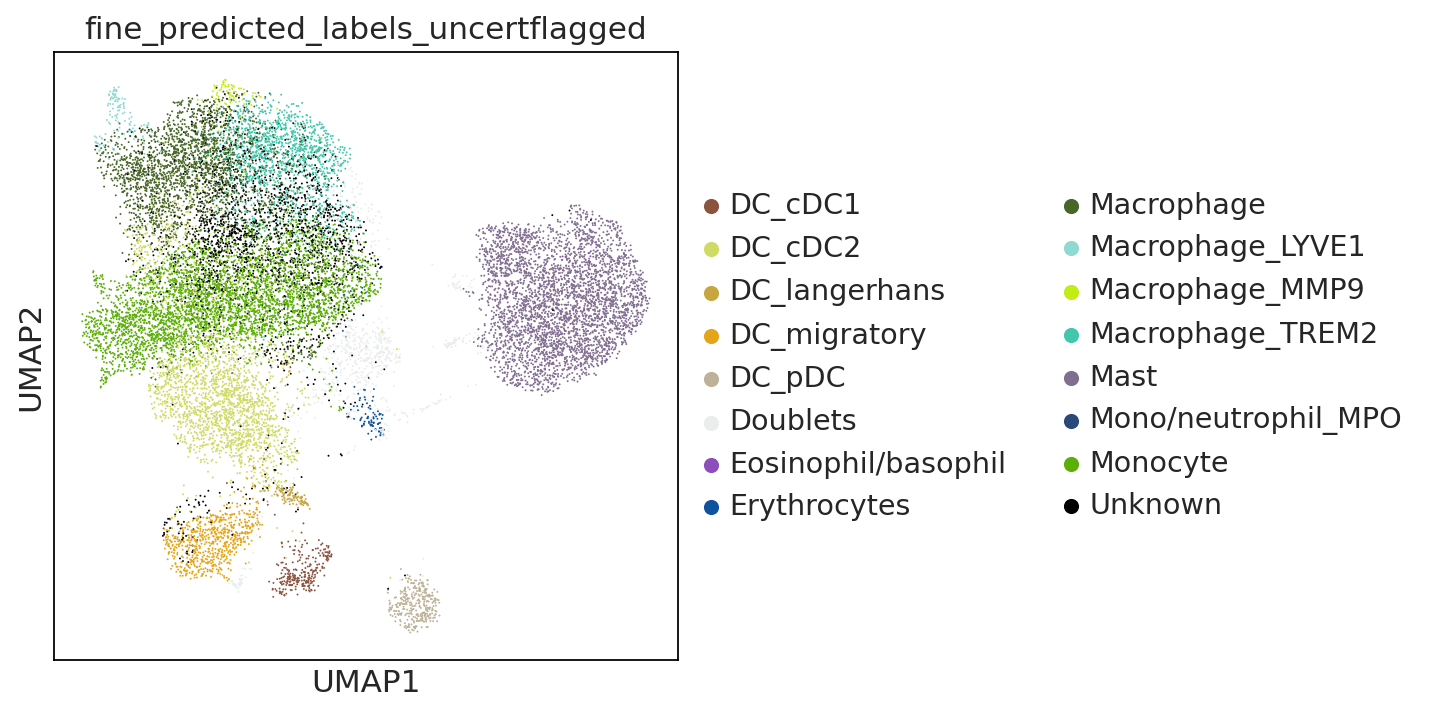

In [31]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged',palette = ['#8c543f',#DC_cDC1
'#cfdb65',#DC_cDC2
'#c7a642',#DC_langerhans
'#e6a519',#DC_migratory
'#bdb197',#DC_pDC
 '#ebeded',#doublets
'#8b4eba',#Eosinophil/basophil
'#0e539c',#Erythrocytes
'#486626',#Macrophage
#'#caf9cf',#Macrophage_CD5L
'#8fd9d0',#Macrophage_LYVE1
'#c1ed15',#Macrophage_MMP9
'#42c7ac',#Macrophage_TREM2
'#826e91',#Mast
#'#c730aa',#Megakaryocyte/platelet
'#2a497a',#Mono/neutrophil_MPO
'#5baf07',#Monocyte 
'#000000'#unknown
                                                                       ],size=3,save='Mye_scanviannot_uncertflagged.pdf')

In [32]:
annot = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/disease_annot/resolved_annot/Myeloid_disease_annot.csv',index_col=0)

In [33]:
annot

fine_predicted_labels_uncertflagged  \
index                                                                  
AACGTTGCACATCCGG-4918STDY7273964                             DC_cDC2   
AACGTTGGTCTGGTCG-4918STDY7273964                            Doublets   
ACACCCTTCCACTGGG-4918STDY7273964                             DC_cDC2   
ACCGTAATCCAGTAGT-4918STDY7273964                                Mast   
ACGGAGAAGGCCATAG-4918STDY7273964                            Monocyte   
...                                                              ...   
TTCTACACAAAGGTGC-GSM4546346                                 Monocyte   
TTGCCGTCACCTCGGA-GSM4546346                                   DC_pDC   
TTGCCGTCATCCTTGC-GSM4546346                                  DC_cDC2   
TTGGCAACACAGATTC-GSM4546346                                  DC_cDC2   
TTTGTCAGTCGCCATG-GSM4546346                                  DC_cDC2   

                                 fine_predicted_labels_resolved  
index                                                            
AACGTTGCACATCCGG-4918STDY7273964                        DC_cDC2  
AACGTTGGTCTGGTCG-4918STDY7273964                       Doublets  
ACACCCTTCCACTGGG-4918STDY7273964                        DC_cDC2  
ACCGTAATCCAGTAGT-4918STDY7273964                           Mast  
ACGGAGAAGGCCATAG-4918STDY7273964                       Monocyte  
...                                                         ...  
TTCTACACAAAGGTGC-GSM4546346                            Monocyte  
TTGCCGTCACCTCGGA-GSM4546346                              DC_pDC  
TTGCCGTCATCCTTGC-GSM4546346                             DC_cDC2  
TTGGCAACACAGATTC-GSM4546346                             DC_cDC2  
TTTGTCAGTCGCCATG-GSM4546346                             DC_cDC2  

[18221 rows x 2 columns]

In [34]:
adata.obs['fine_predicted_labels_resolved'] = annot.fine_predicted_labels_resolved

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


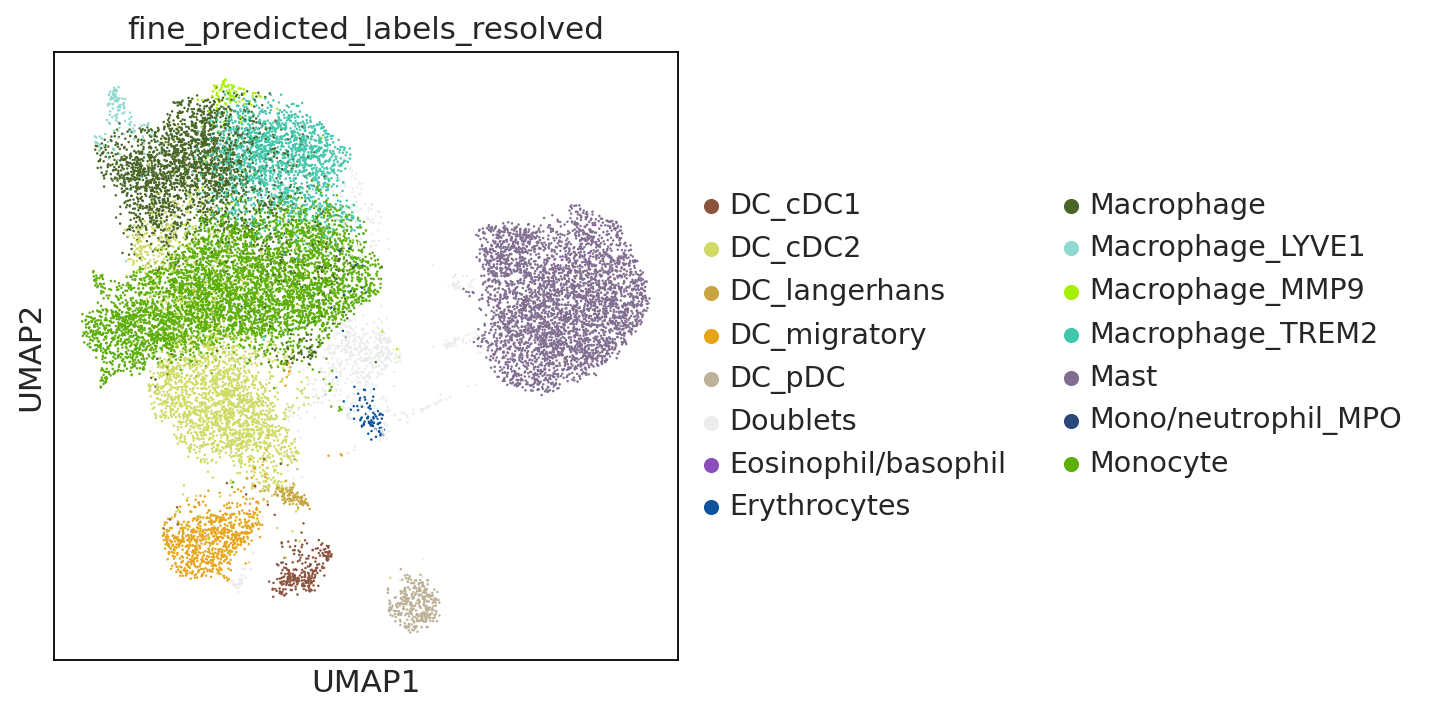

In [35]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_resolved',palette = ['#8c543f',#DC_cDC1
'#cfdb65',#DC_cDC2
'#c7a642',#DC_langerhans
'#e6a519',#DC_migratory
'#bdb197',#DC_pDC
 '#ebeded',#doublets
'#8b4eba',#Eosinophil/basophil
'#0e539c',#Erythrocytes
'#486626',#Macrophage
#'#caf9cf',#Macrophage_CD5L
'#8fd9d0',#Macrophage_LYVE1
'#a5f002',#Macrophage_MMP9
'#42c7ac',#Macrophage_TREM2
'#826e91',#Mast
#'#c730aa',#Megakaryocyte/platelet
'#2a497a',#Mono/neutrophil_MPO
'#5baf07',#Monocyte 
    
                                              ],size=5,save='Mye_scanviannot_resolved.pdf')

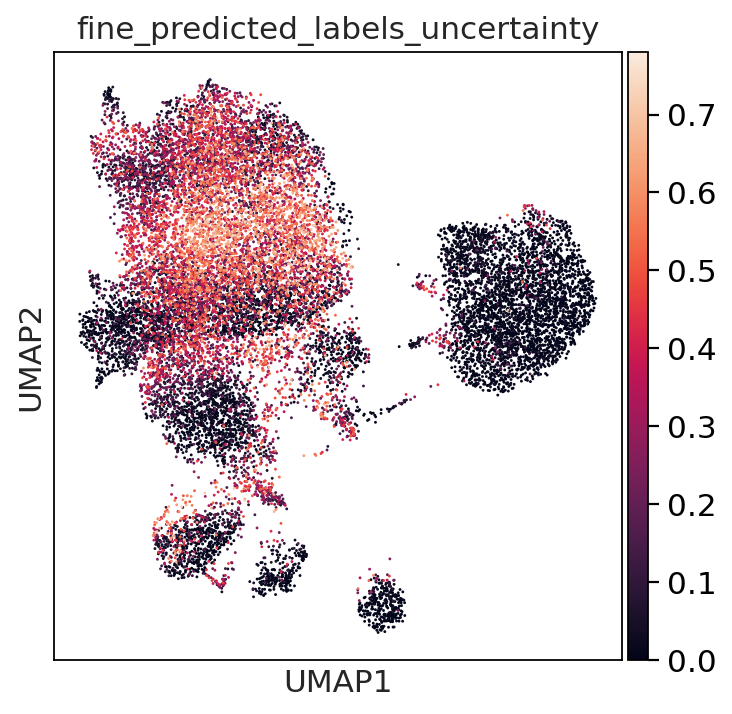

In [36]:
sc.pl.umap(adata,color='fine_predicted_labels_uncertainty',save='Mye_scanviannot_uncertainty.pdf')

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


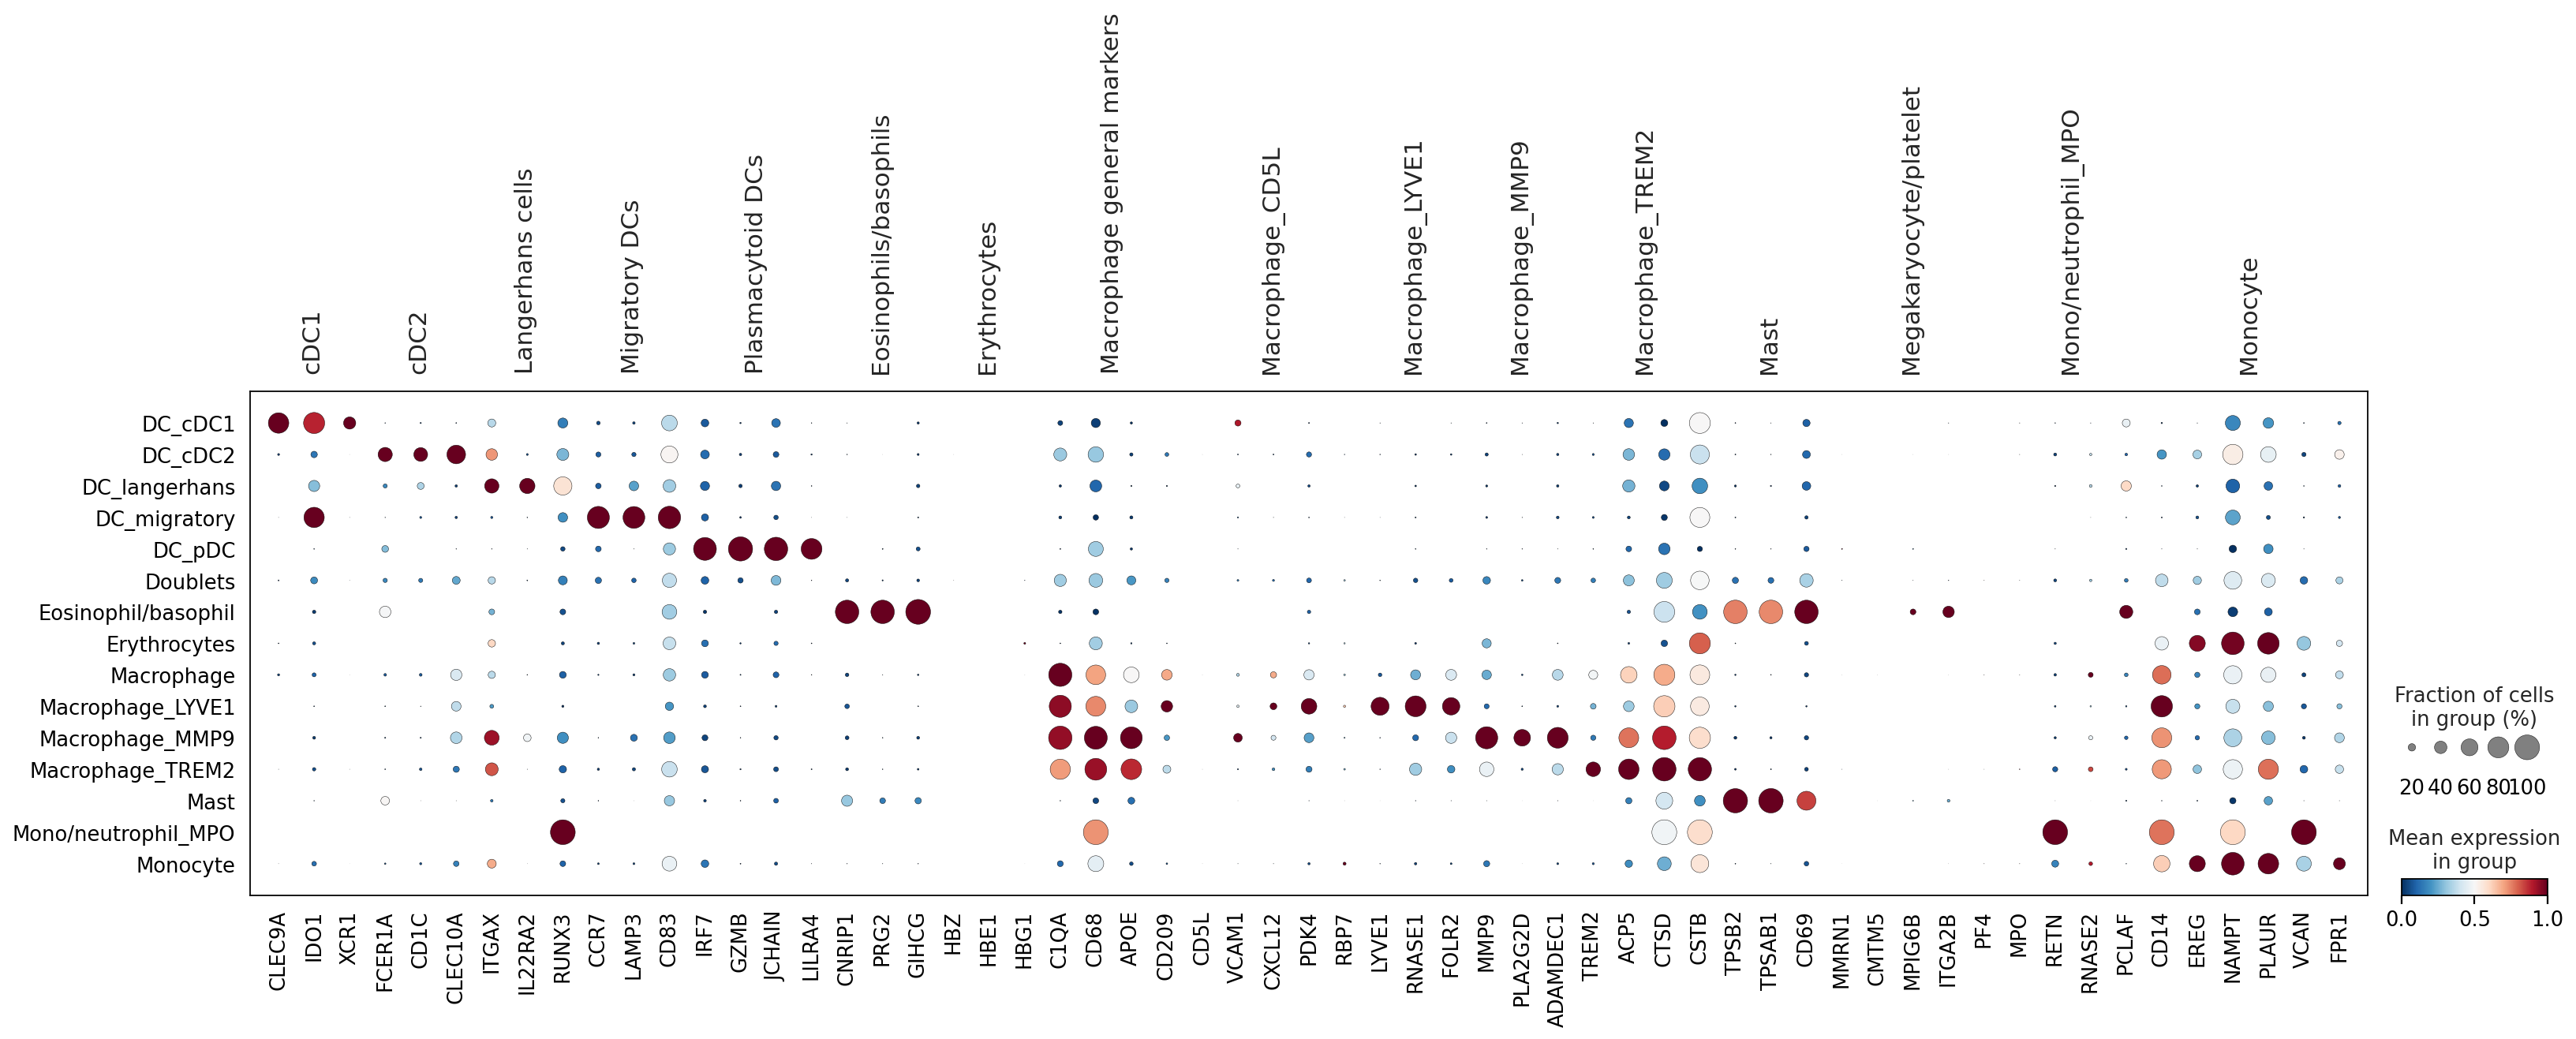

In [37]:
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels_resolved',color_map='RdBu_r', standard_scale='var',save='Mye_scanviannot_resvoledmarkers.pdf')

In [38]:
colors={
    'Doublets':'#ebeded',
    'EC_venous': '#2a4858',
  'Mast': '#826e91',
  'EC_capillary': '#855f9a',
  'DC_cDC1': '#8c543f',
  'Monocyte': '#5baf07',
  'DC_cDC2': '#cfdb65',
  'Basal': '#727271',
  'Treg_IL10': '#e5c510',
  'Crypt_fibroblast_PI16': '#bd7879',
  'Macrophage': '#486626',
  'Vascular_smooth_muscle': '#1E4147',
  'Lamina_propria_fibroblast_ADAMDEC1': '#e95e50',
  'Epithelial_cycling_G2M': '#ff3c4b',
  'Keratinocyte_stratified': '#EDD3E0',
  'Trm/em_CD8': '#256b87',
  'Pericyte': '#437356',
  'Oral_mucosa_fibroblast': '#303267',
  'Macrophage_MMP9': '#a5f002',
  'EC_lymphatic': '#999999',
  'Rectum_fibroblast': '#522e25',
  'Trm_Th17': '#1e093f',
  'DC_migratory': '#e6a519',
  'Epithelial_cycling_S': '#ff8433',
  'Trm_CD4': '#8107ed',
  'NK_CD16': '#0c1e0e',
  'Macrophage_LYVE1': '#8fd9d0',
  'Trm_CD8': '#2844c1',
  'Macrophage_TREM2': '#42c7ac',
  'Keratinocyte_inflammatory': '#E0AC9D',
  'Tnaive/cm_CD4': '#9c53bc',
  'DC_pDC': '#bdb197',
  'Villus_fibroblast_F3': '#d64582',
  'EC_arterial_2': '#ca6092',
  'EC_arterial_1': '#fa6e6e',
  'gdT': '#3fafb5',
  'B_memory': '#a33c22',
  'T/NK_cycling': '#c260ff',
  'Immune_recruiting_pericyte': '#AAC789',
  'MAIT': '#21b796',
  'ILC3': '#778c00',
  'Melanocyte': '#886F61',
  'Tfh_naive': '#5e3c55',
  'Keratinocyte_outer': '#BF7A9C',
  'EC_cycling': '#fac06e',
  'Tnaive/cm_CD8': '#5ca4ce',
  'NK_CD56bright': '#3f8c08',
  'B_naive': '#9b0319',
  'B_preB': '#8a4682',
  'Treg': '#f98261',
  'B_proB': '#d34794',
  'B_plasmablast': '#9e53db',
  'B_plasma_IgG': '#632f17',
  'Megakaryocyte/platelet': '#c730aa',
  'TA': '#b85f1c',
  'Mono/neutrophil_MPO': '#2a497a',
  'B_plasma_IgA1': '#f76c56',
  'Macrophage_CD5L': '#caf9cf',
  'Tfh': '#5e0b30',
  'Oesophagus_fibroblast': '#63A0C0',
  'B_plasma_IgA2': '#d6558d',
  'gdT_naive': '#26daf2',
  'B_GC_I': '#db9602',
  'B_plasma_IgM': '#c66d31',
  'DC_langerhans': '#c7a642',
  'Fibroblast_reticular': '#f0c134',
  'B_GC_II': '#e2d138',
  'Follicular_DC': '#f0982c',
  'Microfold': '#e55b85',
  'Enterocyte': '#e1b5e6',
  'Epithelial_stem': '#c924b9',
  'Surface_foveolar': '#d9b74a',
  'Mucous_gland_neck': '#f7b37c',
  'Cycling': '#ff8433',
  'Pareital': '#d45f80',
  'Enteroendocrine_MX': '#292663',
  'Myofibroblast': '#CCAE91',
  'Glial_2': '#0D6986',
  'Enteric_neural_crest_cycling': '#DBA507',
  'Enterochromaffin': '#22517a',
  'Chief': '#c95340',
  'Glial/Enteric_neural_crest': '#a8c545',
  'Enteroendocrine_G': '#2f3f4d',
  'Neuroblast': '#c50637',
  'Goblet_progenitor': '#e9f7ad',
  'Goblet': '#6c9939',
  'Enteroendocrine': '#68b7fc',
  'Erythrocytes': '#0e539c',
  'Enteroendocrine_X': '#7292ad',
  'Glial_3': '#053240',
  'Goblet_cycling': '#d1d14f',
  'BEST4_enterocyte_colonocyte': '#39997c',
  'Tuft': '#9d9dff',
  'Paneth': '#79508f',
  'Serous': '#C9DE55',
  'Mucous': '#67cc8e',
  'Duct': '#7D9100',
  'Seromucous': '#ACEBAE',
  'Myoepithelial': '#572300',
  'Ionocytes': '#9d9dff',
  'Colonocyte': '#d66245',
  'Mature_colonocyte': '#fa6161',
  'Mesoderm_2': '#b4793b',
  'Branch_A_inhibtory_motor_neuron': '#a39bcb',
  'SMC_PPLP2': '#d4d4e8',
  'Cycling_fibroblast': '#d65151',
  'ICC': '#69479b',
  'Branch_B_excitatory_motor_neuron': '#496695',
  'SMC_CAPN3': '#968dc6',
  'Mesoderm_1': '#663818',
  'Branch_B_primary_afferent_neuron': '#909134',
  'Proximal_progenitor_DUO/JEJ': '#fac219',
  'SMC_CAPN3_cycling': '#76738e',
  'Glial_1': '#8EC7D2',
  'Branch_A_primary_afferent_neuron': '#27bdbf',
  'Branch_A_interneuron': '#67608a',
  'NTS': '#baada4',
  'Proximal_progenitor_ILE': '#8f6e0d',
  'Enteroendocrine_progenitor': '#aeebdf',
  'Mesothelium': '#8F6592',
  'Distal_progenitor': '#dbc697',
  'Angiogenic_pericyte': '#308587',
  'Eosinophil/basophil': '#8b4eba',
  'CLDN10': '#706d65',
  'Distal_progenitor_PRAC1': '#8f8161',
  'Immature_pericyte': '#90c496',
  'Mesenchymal_LTO': '#f7eb59',
  'Gastric_fetal_epithelial': '#a01160',
  'DCS_MUC17_cycling': '#99216b',
  'DCS_MUC17': '#9c6b73',
  'Gland_basal': '#404040',
  'Gland_fetal': '#168039',
  'Basal_cycling': '#d1bf82',
  'Keratinocyte_fetal': '#d8306e',
  'Gland_duct': '#7D9100',
  'Gland_mucous': '#67cc8e',
  'Myoblast/myocyte': '#e2798d',
  'Unknown': '#000000'}

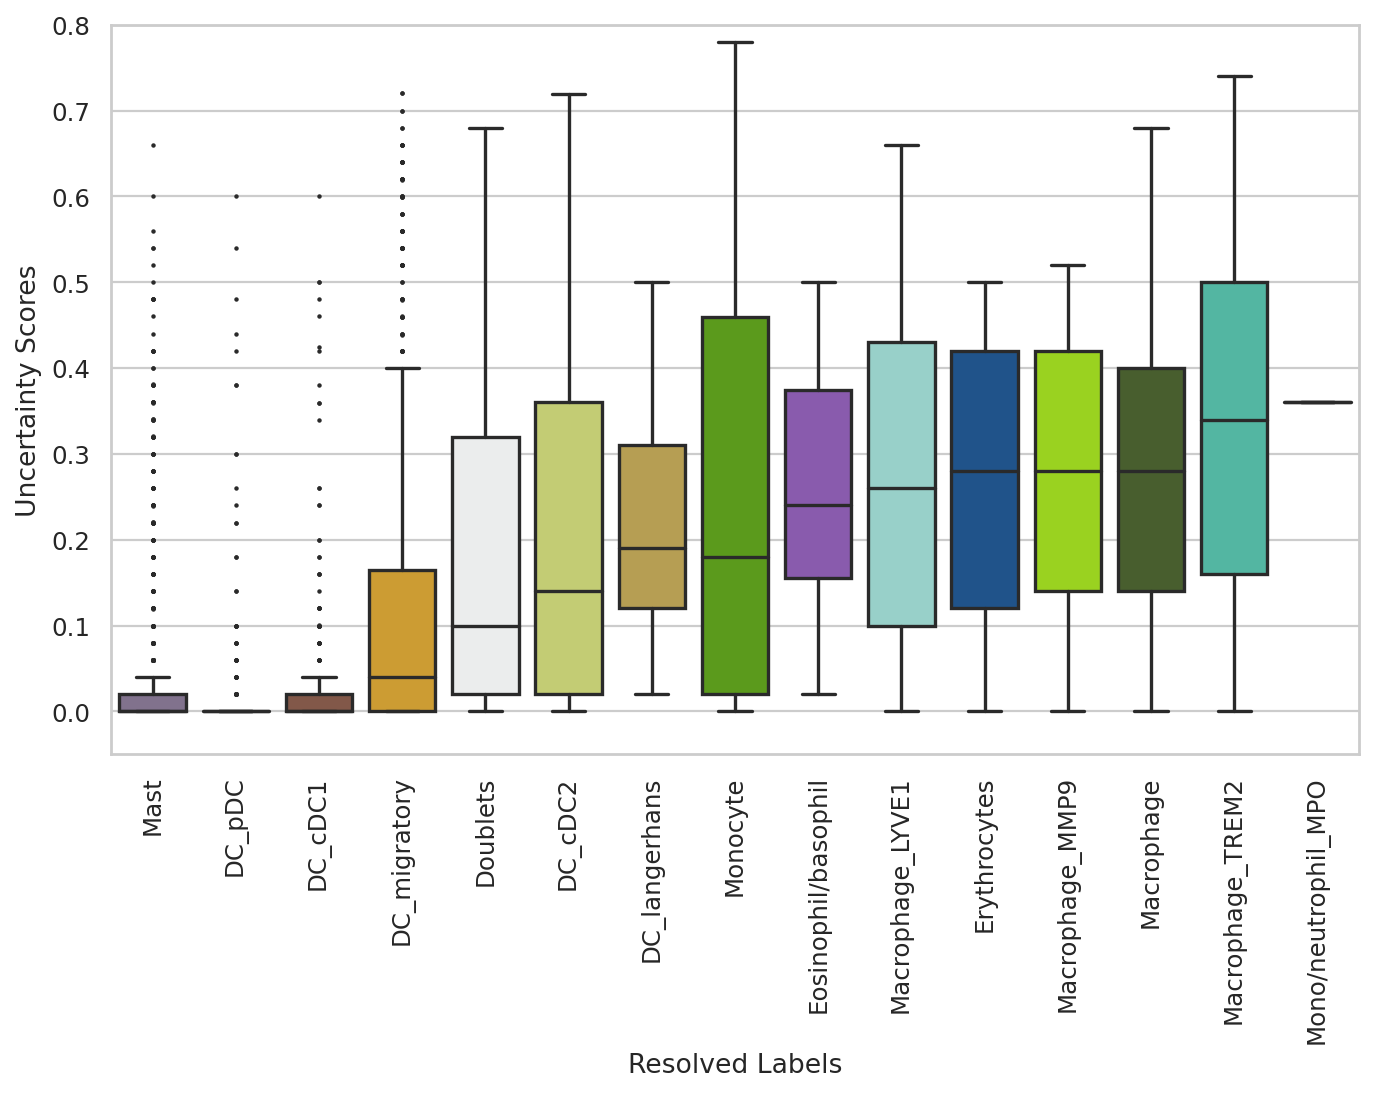

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but seaborn can enhance the style

# Assuming adata is your AnnData object

# Combine the two variables into a DataFrame for easier plotting
data_to_plot = adata.obs[['fine_predicted_labels_uncertainty', 'fine_predicted_labels_resolved']]

# Use seaborn for better styling (optional)
sns.set(style="whitegrid")

mean_uncertainty = data_to_plot.groupby('fine_predicted_labels_resolved')['fine_predicted_labels_uncertainty'].mean()

# Sort the categories based on mean uncertainty
sorted_categories = mean_uncertainty.sort_values().index

# Create a box and whisker plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
ax = sns.boxplot(x='fine_predicted_labels_resolved', y='fine_predicted_labels_uncertainty', 
            data=data_to_plot,palette=colors,order=sorted_categories,flierprops=dict(marker='o', markerfacecolor='gray', markersize=1))

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel('Resolved Labels')
plt.ylabel('Uncertainty Scores')
ax.set_ylim(-0.05, 0.8)

# Save the plot as a PDF file
plt.savefig('Mye_boxplot_uncertainty_scores.pdf', format='pdf')

# Show the plot
plt.show()

In [40]:
#related to revisions point 2.10 "Have you done differential gene expression analysis of the unknonw cells versus the annotated cells in their cluster?"

In [41]:
adata

AnnData object with n_obs × n_vars = 18221 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

In [42]:
adata.obs['unknown_clusterlabel'] = adata.obs['fine_predicted_labels_uncertflagged'].astype(str) + '_' + adata.obs['fine_predicted_labels_resolved'].astype(str)

In [43]:
adata.obs['unknown_clusterlabel'].value_counts()

Monocyte_Monocyte                          4090
Mast_Mast                                  3638
Macrophage_Macrophage                      2419
DC_cDC2_DC_cDC2                            2344
Macrophage_TREM2_Macrophage_TREM2          1337
Unknown_Monocyte                           1093
Doublets_Doublets                           812
DC_migratory_DC_migratory                   685
Unknown_Macrophage_TREM2                    321
DC_pDC_DC_pDC                               320
DC_cDC1_DC_cDC1                             270
Macrophage_LYVE1_Macrophage_LYVE1           169
Unknown_DC_cDC2                             135
Macrophage_MMP9_Macrophage_MMP9             121
DC_langerhans_DC_langerhans                 110
Unknown_Macrophage                          109
Erythrocytes_Erythrocytes                    95
Unknown_DC_migratory                         67
Unknown_Doublets                             52
Eosinophil/basophil_Eosinophil/basophil      14
Unknown_Macrophage_LYVE1                

In [44]:
adata.X.max()

8.59866

In [46]:
adata_compare = adata[~adata.obs.unknown_clusterlabel.isin(['Mono/neutrophil_MPO_Mono/neutrophil_MPO','Unknown_DC_cDC1'])].copy()

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/tools/_rank

         Falling back to preprocessing with `sc.pp.pca` and default params.


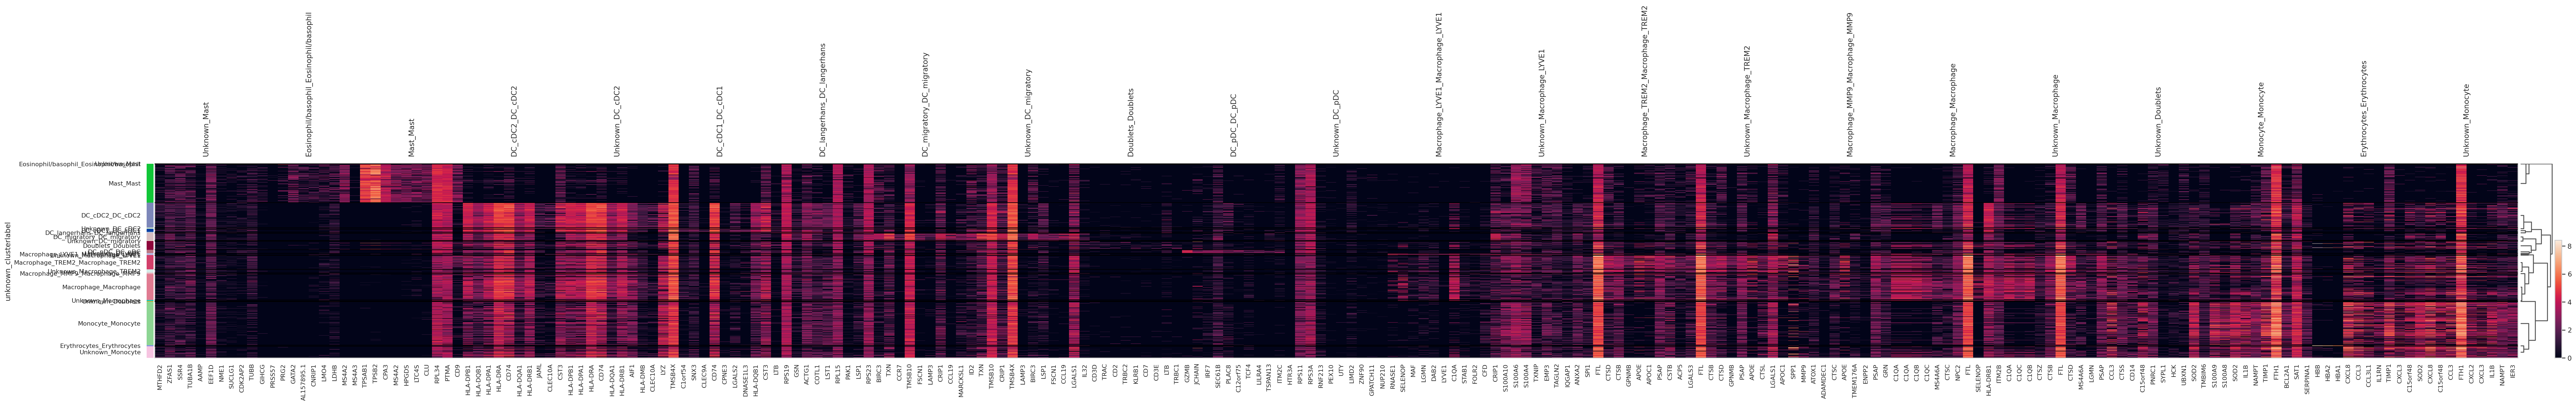

In [47]:
sc.tl.rank_genes_groups(adata_compare, 'unknown_clusterlabel', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_compare, show_gene_labels=True)

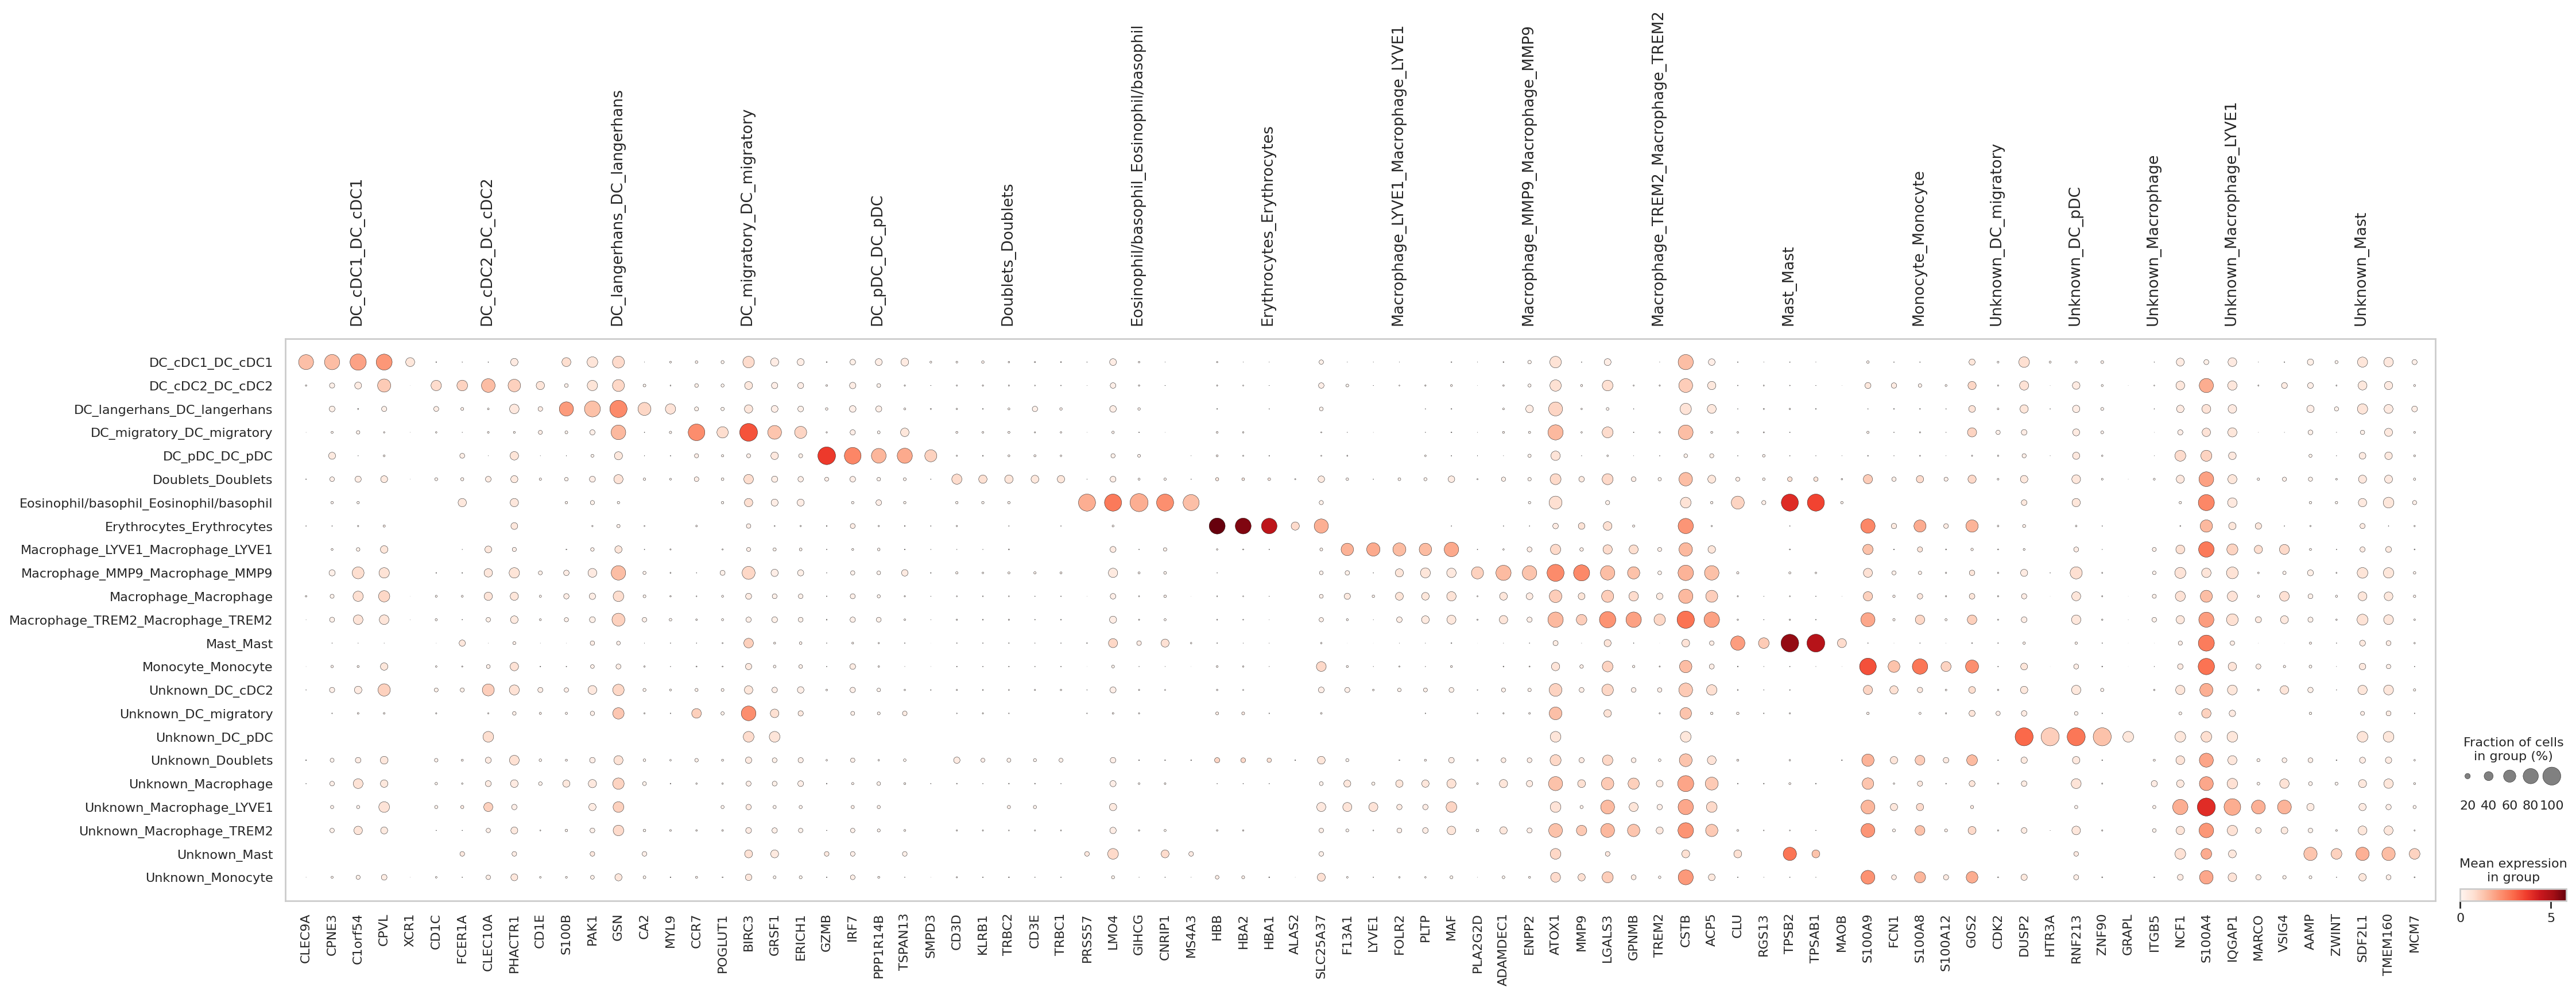

In [48]:
import sys
sys.path.append("/home/jovyan/ao15/Megagut/")
from re5_combine import *
adata_compare.raw = adata_compare.copy()
mkst = calc_marker_stats(adata_compare, groupby="unknown_clusterlabel")
mks = filter_marker_stats(mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.5, max_next_mean=0.95, strict=False, how='or')
plot_markers(adata_compare, groupby='unknown_clusterlabel', mks=mks)

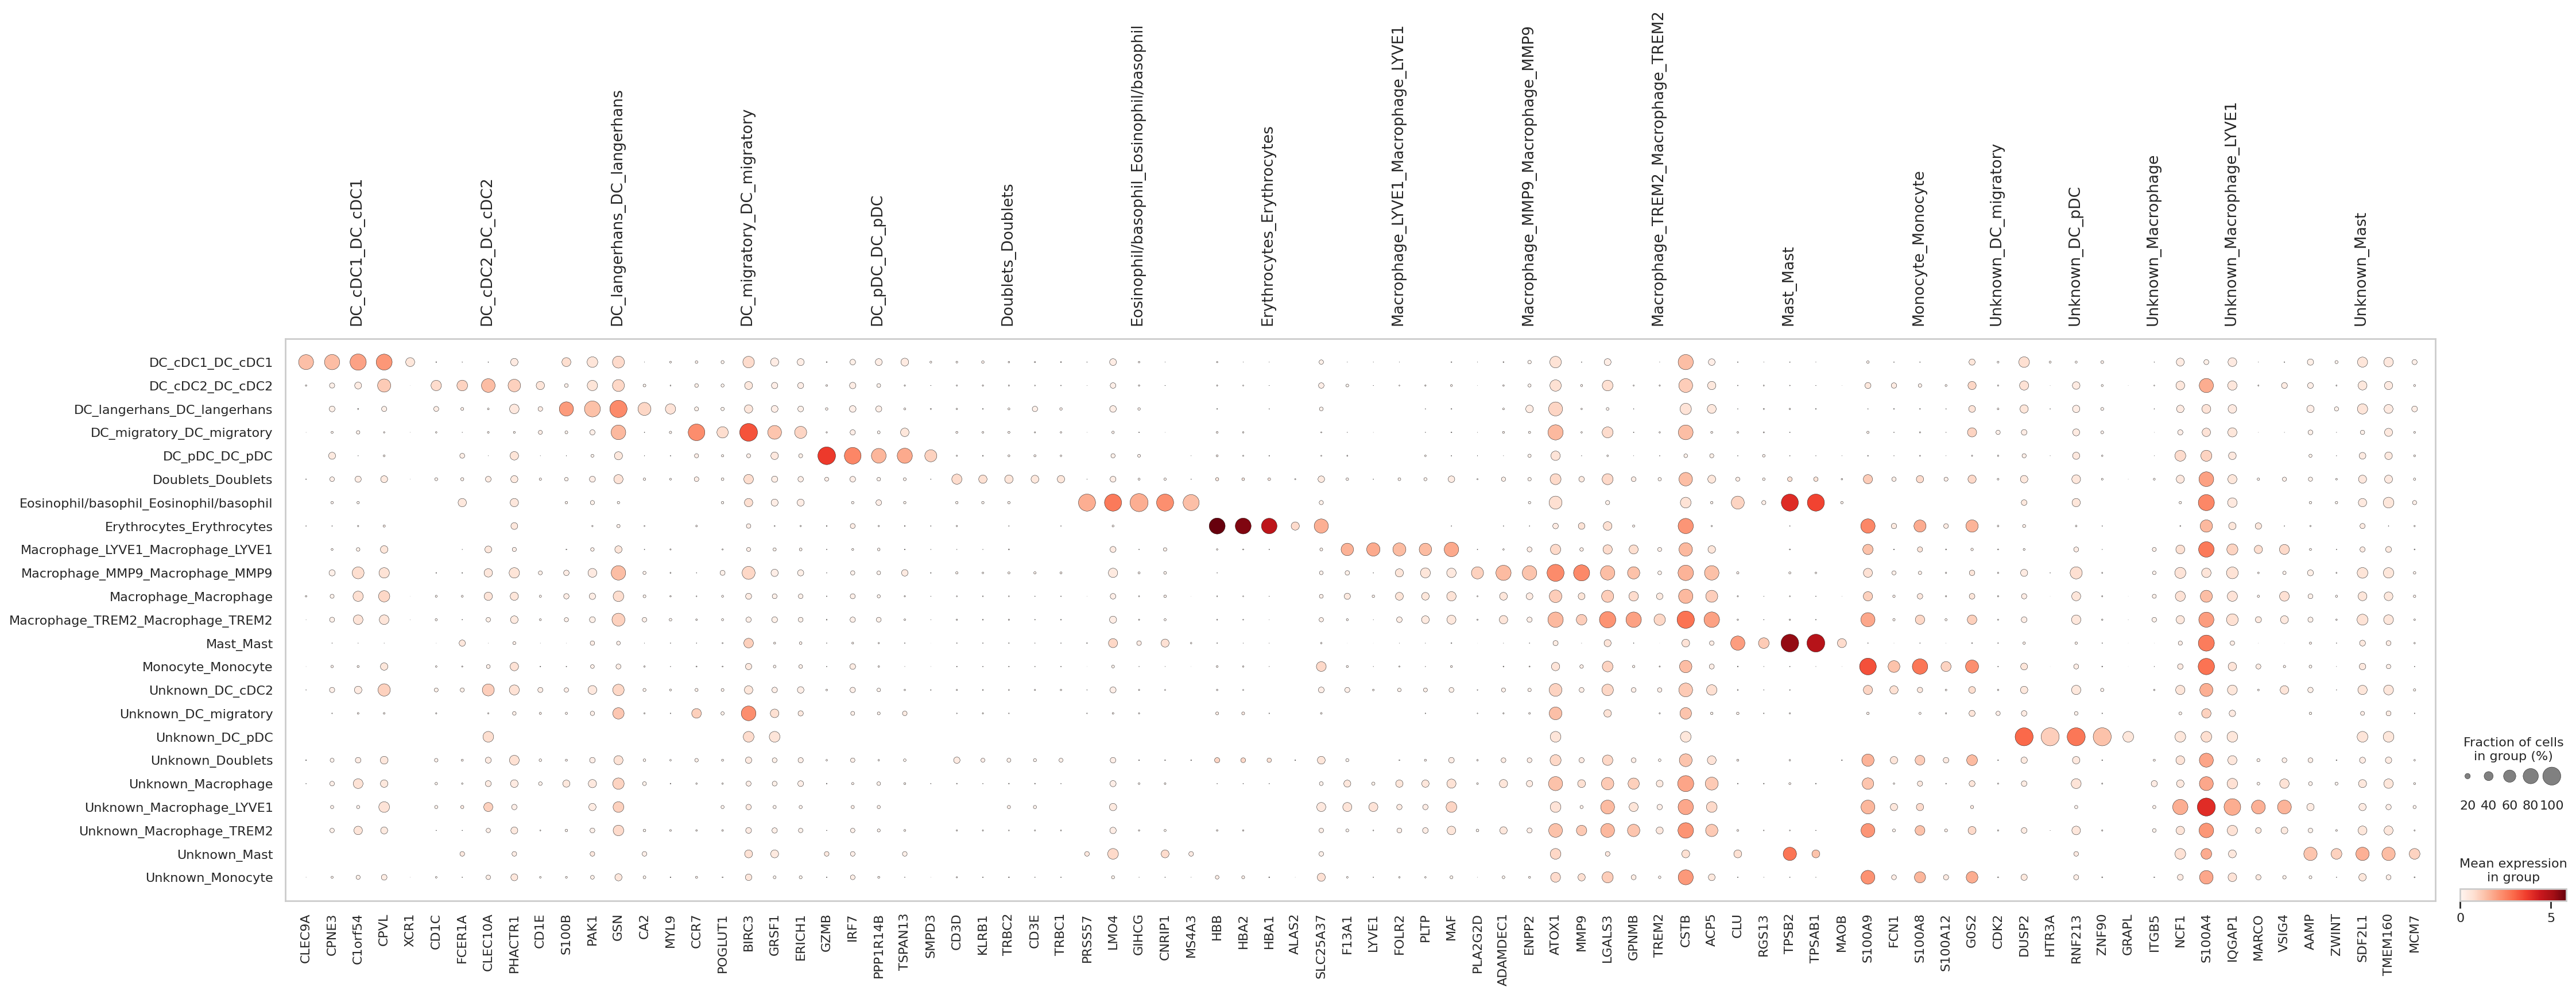

In [49]:
plot_markers(adata_compare, groupby='unknown_clusterlabel', mks=mks,save='Mye_unknown_specificDGE.pdf')